In [ ]:
!pip install --quiet bitnet

In [ ]:
from API import WANDB_TOKEN, HF_TOKEN

DATASET           = "dennlinger/eur-lex-sum"
model_name        = "MikaSie/LegalBERT_BART_fixed_V1"
# model_name        = "facebook/bart-large-cnn" 
CONTEXT_LENGTH    = 256

In [17]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset
from bitnet import replace_linears_in_hf
from tqdm import tqdm 
import torch
import wandb

wandb.init(project="summarization", name="LegalBERT_BART_fixed_V1_quantized", config={
    "model_name": "MikaSie/LegalBERT_BART_fixed_V1",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "max_length": 150,
    "num_beams": 4
})

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

model_size = sum(t.numel() for t in model.parameters())
print(f"Model size before quantization: {model_size / 1000 ** 2:.1f}M parameters")


model = torch.quantization.quantize_dynamic( 
    model,                                 # Quantize the model for inference (dynamic quantization)
    {torch.nn.Linear},                     # Quantize only the Linear layers for faster inference
    dtype=torch.qint8                      # Use 8-bit integer quantization
)

model_size = sum(t.numel() for t in model.parameters())
print(f"Model size after quantization: {model_size / 1000 ** 2:.1f}M parameters")

model.to(device)

data         = load_dataset("dennlinger/eur-lex-sum", "english", trust_remote_code=True)
texts        = data['test']['reference'][:10]
gt_summaries = data['test']['summary'][:10]
summaries    = []

for idx, text in tqdm(enumerate(texts),total = len(texts)):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=CONTEXT_LENGTH).to(device)
    
    
    model.eval()          # Evaluation mode 
    with torch.no_grad(): # Perform inference
        outputs = model.generate(**inputs, max_length=CONTEXT_LENGTH, num_beams=4, early_stopping=True)
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    summaries.append(summary)

    wandb.log({
        f"summary_{idx + 1}": summary,
        f"input_{idx + 1}": text,
        f"length_of_summary_{idx + 1}": len(summary.split())
    })

wandb.finish()

wandb: Currently logged in as: ztudorita (unibe-tudi). Use `wandb login --relogin` to force relogin


Model size before quantization: 406.3M parameters
Model size after quantization: 53.7M parameters


100%|██████████| 10/10 [02:32<00:00, 15.21s/it]


length_of_summary_1,▁
length_of_summary_10,▁
length_of_summary_2,▁
length_of_summary_3,▁
length_of_summary_4,▁
length_of_summary_5,▁
length_of_summary_6,▁
length_of_summary_7,▁
length_of_summary_8,▁
length_of_summary_9,▁
input_1,12.7.2019 EN Officia...


In [18]:
!pip install --quiet bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
from bert_score import score

P, R, F1 = score(summaries,gt_summaries, model_type="bert-base-uncased", lang="en")

In [20]:
import numpy as np 
print("\nBERTScore Model Benchmark Results:")
print(f"Precision: Mean = {torch.mean(P):.4f}, Std = {torch.std(P):.4f}")
print(f"Recall   : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")
print(f"F1-score : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")


BERTScore Model Benchmark Results:
Precision: Mean = 0.5135, Std = 0.0160
Recall   : Mean = 0.4186, Std = 0.0120
F1-score : Mean = 0.4186, Std = 0.0120


In [21]:
!pip install --quiet rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
from rouge_score import rouge_scorer
from tqdm import tqdm 

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store scores
bitnet_rouge1_scores, bitnet_rouge2_scores, bitnet_rougeL_scores = [], [], []

for summary, gt_summary in tqdm(zip(summaries, gt_summaries), total=len(summaries)):
    # Generate summary
    scores = scorer.score(gt_summary, summary)
    bitnet_rouge1_scores.append(scores['rouge1'].fmeasure)
    bitnet_rouge2_scores.append(scores['rouge2'].fmeasure)
    bitnet_rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score
    reference = gt_summary.split()  # Tokenized reference summary
    candidate = summary.split()  # Tokenized generated summary

import numpy as np

# Calculate mean and standard deviation for each metric
bitnet_rouge1_mean, bitnet_rouge1_std = np.mean(bitnet_rouge1_scores), np.std(bitnet_rouge1_scores)
bitnet_rouge2_mean, bitnet_rouge2_std = np.mean(bitnet_rouge2_scores), np.std(bitnet_rouge2_scores)
bitnet_rougeL_mean, bitnet_rougeL_std = np.mean(bitnet_rougeL_scores), np.std(bitnet_rougeL_scores)

print("\nBitNet Model Full Precision Benchmark Results:")
print(f"ROUGE-1: Mean = {bitnet_rouge1_mean:.4f}, Std = {bitnet_rouge1_std:.4f}")
print(f"ROUGE-2: Mean = {bitnet_rouge2_mean:.4f}, Std = {bitnet_rouge2_std:.4f}")
print(f"ROUGE-L: Mean = {bitnet_rougeL_mean:.4f}, Std = {bitnet_rougeL_std:.4f}")

100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


BitNet Model Full Precision Benchmark Results:
ROUGE-1: Mean = 0.2084, Std = 0.0376
ROUGE-2: Mean = 0.0699, Std = 0.0167
ROUGE-L: Mean = 0.1401, Std = 0.0258


# Baseline 

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

for idx, text in tqdm(enumerate(texts),total = len(texts)):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=CONTEXT_LENGTH).to(device)
    
    model.eval()          # Evaluation mode 
    with torch.no_grad(): # Perform inference
        outputs = model.generate(**inputs, max_length=CONTEXT_LENGTH, num_beams=4, early_stopping=True)
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    summaries.append(summary)
    
    scores = scorer.score(gt_summary, summary)
    bitnet_rouge1_scores.append(scores['rouge1'].fmeasure)
    bitnet_rouge2_scores.append(scores['rouge2'].fmeasure)
    bitnet_rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score
    reference = gt_summary.split()  # Tokenized reference summary
    candidate = summary.split()  # Tokenized generated summary

In [28]:
P, R, F1 = score(summaries,gt_summaries, model_type="bert-base-uncased", lang="en")
print("\nBERTScore Model Benchmark Results:")
print(f"Precision: Mean = {torch.mean(P):.4f}, Std = {torch.std(P):.4f}")
print(f"Recall   : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")
print(f"F1-score : Mean = {torch.mean(R):.4f}, Std = {torch.std(R):.4f}")

# Calculate mean and standard deviation for each metric
bitnet_rouge1_mean, bitnet_rouge1_std = np.mean(bitnet_rouge1_scores), np.std(bitnet_rouge1_scores)
bitnet_rouge2_mean, bitnet_rouge2_std = np.mean(bitnet_rouge2_scores), np.std(bitnet_rouge2_scores)
bitnet_rougeL_mean, bitnet_rougeL_std = np.mean(bitnet_rougeL_scores), np.std(bitnet_rougeL_scores)

print("\nBitNet Model Full Precision Benchmark Results:")
print(f"ROUGE-1: Mean = {bitnet_rouge1_mean:.4f}, Std = {bitnet_rouge1_std:.4f}")
print(f"ROUGE-2: Mean = {bitnet_rouge2_mean:.4f}, Std = {bitnet_rouge2_std:.4f}")
print(f"ROUGE-L: Mean = {bitnet_rougeL_mean:.4f}, Std = {bitnet_rougeL_std:.4f}")


BERTScore Model Benchmark Results:
Precision: Mean = 0.6822, Std = 0.0334
Recall   : Mean = 0.5855, Std = 0.0317
F1-score : Mean = 0.5855, Std = 0.0317

BitNet Model Full Precision Benchmark Results:
ROUGE-1: Mean = 0.1971, Std = 0.0318
ROUGE-2: Mean = 0.0749, Std = 0.0216
ROUGE-L: Mean = 0.1210, Std = 0.0275


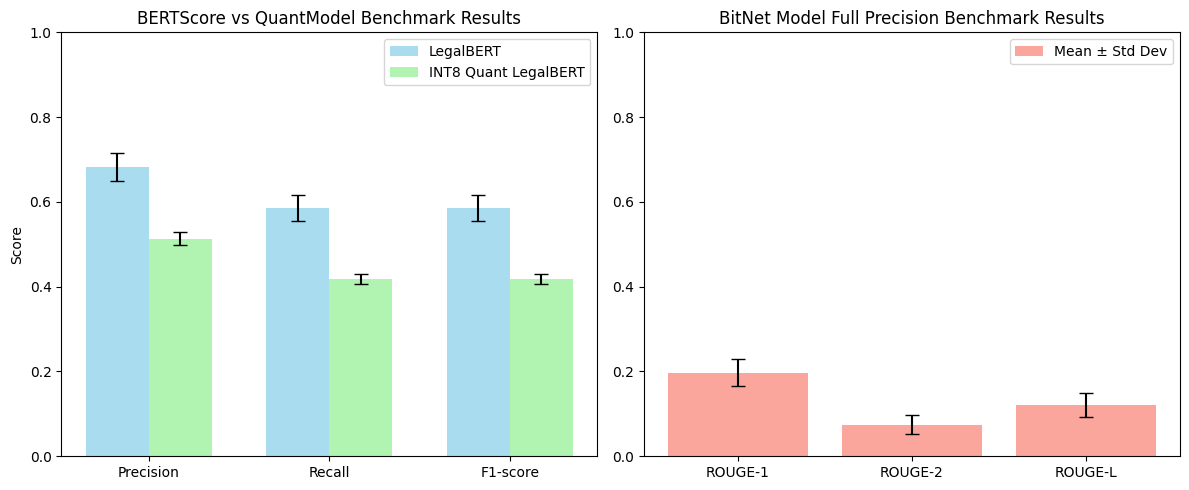

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data for BERTScore Model Benchmark Results
bert_metrics = ['Precision', 'Recall', 'F1-score']
bert_means = [0.6822, 0.5855, 0.5855]
bert_stds = [0.0334, 0.0317, 0.0317]

# Data for BERTScore QuantModel Benchmark Results
quant_means = [0.5135, 0.4186, 0.4186]
quant_stds = [0.0160, 0.0120, 0.0120]

# Data for BitNet Model Full Precision Benchmark Results
bitnet_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
bitnet_means = [0.1971, 0.0749, 0.1210]
bitnet_stds = [0.0318, 0.0216, 0.0275]

# Plotting the bar charts
x = np.arange(len(bert_metrics))  # The label locations
width = 0.35  # Width of the bars

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# BERTScore and QuantModel combined bar chart
axs[0].bar(x - width/2, bert_means, width, yerr=bert_stds, capsize=5, color='skyblue', alpha=0.7, label='LegalBERT')
axs[0].bar(x + width/2, quant_means, width, yerr=quant_stds, capsize=5, color='lightgreen', alpha=0.7, label='INT8 Quant LegalBERT')
axs[0].set_title('BERTScore vs QuantModel Benchmark Results')
axs[0].set_xticks(x)
axs[0].set_xticklabels(bert_metrics)
axs[0].set_ylabel('Score')
axs[0].set_ylim(0, 1)
axs[0].legend()

# BitNet bar chart
x_bitnet = np.arange(len(bitnet_metrics))
axs[1].bar(x_bitnet, bitnet_means, yerr=bitnet_stds, capsize=5, color='salmon', alpha=0.7, label='Mean ± Std Dev')
axs[1].set_title('BitNet Model Full Precision Benchmark Results')
axs[1].set_xticks(x_bitnet)
axs[1].set_xticklabels(bitnet_metrics)
axs[1].set_ylim(0, 1)
axs[1].legend()

plt.tight_layout()
plt.show()
